In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.linear_model import LogisticRegression

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
model_path = "runs/20241115-172401/model_1990000.pt"
model = QNetwork(model_path=model_path)

concept = concept_instances['Visible ghost']
concept.prepare_data(env_steps, max_size=10000)

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loaded model: 20241115-172401-1990000


In [4]:
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)
test_obs = torch.tensor(concept.test_obs.copy()).float()
test_values = torch.tensor(concept.test_values, dtype=torch.float32)
_, acts_dict_train = model(train_obs, return_acts=True)
_, acts_dict_test = model(test_obs, return_acts=True)

In [5]:
layer = 0
test_activations = acts_dict_test[layer]
test_activations.requires_grad_(True)
test_activations.shape

torch.Size([464, 32, 20, 20])

In [6]:
max_q_values = model.network[layer + 1:](test_activations).max(dim=1)[0]
max_q_values.backward(torch.ones_like(max_q_values))
activations_grad1 = test_activations.grad.clone()
test_activations.grad.zero_()
activations_grad1.shape

torch.Size([464, 32, 20, 20])

In [7]:
max_q_values = model.network[layer + 1:](test_activations).max(dim=1)[0]
grads = torch.autograd.grad(
    outputs=max_q_values,
    inputs=test_activations,
    grad_outputs=torch.ones_like(max_q_values),
    retain_graph=True,
    create_graph=True
)
test_activations.grad = grads[0]
activations_grad2 = test_activations.grad.clone()

test_activations.requires_grad_(False)

(activations_grad1 == activations_grad2).all()

tensor(True)

In [8]:
# manually compute gradients using the definition of derivatives
h = 0.001
activations_grad_manual = test_activations[0].clone().unsqueeze(0)
activations_grad_manual.shape

idx = (0, 0, 0, 3)

activation_plus_h = activations_grad_manual.clone()
activation_minus_h = activations_grad_manual.clone()
activation_plus_h[idx] += h
activation_minus_h[idx] -= h

forward_pass_plus_h = model.network[layer + 1:](activation_plus_h).max(dim=1)[0]
forward_pass_minus_h = model.network[layer + 1:](activation_minus_h).max(dim=1)[0]
activations_grad_manual = (forward_pass_plus_h - forward_pass_minus_h) / (2.0 * h)
print(activations_grad_manual)
print(activations_grad1[idx])

tensor([0.], grad_fn=<DivBackward0>)
tensor(0.)


In [9]:
x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

lr = LogisticRegression(max_iter=500, solver='liblinear', penalty='l1', C=1)
lr.fit(x_data_train, y_data_train)
lr.score(x_data_test, y_data_test)

0.9978448275862069

In [10]:
flat_activations_grad = activations_grad1.flatten(start_dim=1).cpu().numpy()
print(flat_activations_grad.shape)
flat_weights = lr.coef_[0]
print(flat_weights.shape)

(464, 12800)
(12800,)


In [11]:
norm_direction = flat_weights / np.linalg.norm(flat_weights)
directional_derivatives = np.dot(flat_activations_grad, norm_direction)

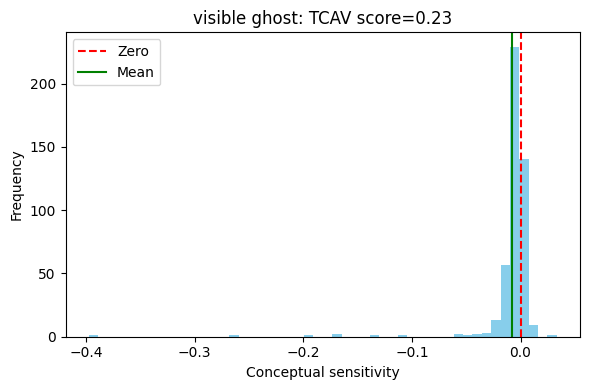

In [12]:
mean_value = np.mean(directional_derivatives)
positive_fraction = np.mean(directional_derivatives > 0)
plt.figure(figsize=(6, 4))
plt.hist(directional_derivatives, bins=50, color='skyblue')
plt.xlabel('Conceptual sensitivity')
plt.ylabel('Frequency')
plt.title(f"{concept.name}: TCAV score={positive_fraction:.2f}")

plt.axvline(x=0, color='r', linestyle='--', label='Zero')
plt.axvline(x=mean_value, color='green', linestyle='-', label='Mean')
plt.tight_layout()
plt.legend()
plt.show()

### Some action statistics

In [13]:
action_names = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']
concept = concept_instances['Visible ghost']
concept.prepare_data(env_steps, max_size=10000)
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)

train_ghost = train_obs[train_values == 1]
train_no_ghost = train_obs[train_values == 0]

indices_ghost = model(train_ghost).max(dim=1)[1].cpu().numpy()
indices_no_ghost = model(train_no_ghost).max(dim=1)[1].cpu().numpy()

print("Ghost actions (ghost / no ghost):")
for action in action_names:
    prob_ghost = 100 * np.mean(indices_ghost == action_names.index(action))
    prob_no_ghost = 100 * np.mean(indices_no_ghost == action_names.index(action))
    print(f"{action}: {prob_ghost:.2f}% / {prob_no_ghost:.2f}% = {prob_ghost / prob_no_ghost:.2f}")


Ghost actions (ghost / no ghost):
NOOP: 0.22% / 1.40% = 0.15
LEFT: 57.87% / 1.51% = 38.36
RIGHT: 35.02% / 75.00% = 0.47
JUMP: 3.34% / 17.56% = 0.19
DODGE: 3.56% / 4.53% = 0.79


In [14]:
concept = concept_instances['Visible gold coin']
concept.prepare_data(env_steps, max_size=10000)
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)

train_coin = train_obs[train_values == 1]
train_no_coin = train_obs[train_values == 0]

indices_coin = model(train_coin).max(dim=1)[1].cpu().numpy()
indices_no_coin = model(train_no_coin).max(dim=1)[1].cpu().numpy()

print("Gold coin actions (coin / no coin):")
for action in action_names:
    prob_coin = 100 * np.mean(indices_coin == action_names.index(action))
    prob_no_coin = 100 * np.mean(indices_no_coin == action_names.index(action))
    print(f"{action}: {prob_coin:.2f}% / {prob_no_coin:.2f}% = {prob_coin / prob_no_coin:.2f}")

Gold coin actions (coin / no coin):
NOOP: 0.74% / 1.72% = 0.43
LEFT: 3.69% / 10.34% = 0.36
RIGHT: 72.17% / 67.73% = 1.07
JUMP: 14.53% / 14.29% = 1.02
DODGE: 8.87% / 5.91% = 1.50


In [81]:
concept = concept_instances['Visible lava']
concept.prepare_data(env_steps, max_size=10000)
train_obs = torch.tensor(concept.train_obs.copy()).float()
# What is the average Q-value for each action when that action is the largest Q-value? (Independent from concept)

q_values = model(train_obs)
# Print the average action Q-values
print(f"Average Q-values for each action")
for i in range(q_values.shape[1]):
    print(f"Action {action_names[i]}: {q_values[:, i].mean():.4f}")
print()

q_values_max, q_values_max_indices = q_values.max(dim=1)

unique_actions = torch.unique(q_values_max_indices)

# Calculate the average Q-value for each action
average_q_values = {}
for action in unique_actions:
    mask = (q_values_max_indices == action)  # Find indices where the action matches
    avg_q = q_values_max[mask].mean()  # Calculate the average Q-value for the action
    average_q_values[action.item()] = avg_q.item()

# Print the results
print("Average Q-values when each action is the largest Q-value:")
for action, avg_q in average_q_values.items():
    print(f"Action {action_names[action]}: {avg_q:.4f}")

Average Q-values for each action
Action NOOP: 0.6060
Action LEFT: 0.5723
Action RIGHT: 0.6361
Action JUMP: 0.6062
Action DODGE: 0.6035

Average Q-values when each action is the largest Q-value:
Action NOOP: 0.5567
Action LEFT: 0.3293
Action RIGHT: 0.7330
Action JUMP: 0.6916
Action DODGE: 0.5286


In [112]:
concept = concept_instances['Visible lava']
concept.prepare_data(env_steps, max_size=10000)
train_obs = torch.tensor(concept.train_obs.copy()).float()
# What is the average Q-value for each action when that action is the largest Q-value? (Independent from concept)

q_values = model(train_obs)
# Print the average action Q-values
print(f"Average Q-values for each action")
for i in range(q_values.shape[1]):
    print(f"Action {action_names[i]}: {q_values[:, i].mean():.4f}")
print()

q_values_max, q_values_max_indices = q_values.max(dim=1)

unique_actions = torch.unique(q_values_max_indices)

# Calculate the average Q-value for each action
average_q_values = {}
for action in unique_actions:
    mask = (q_values_max_indices == action)  # Find indices where the action matches
    avg_q = q_values_max[mask].mean()  # Calculate the average Q-value for the action
    average_q_values[action.item()] = avg_q.item()

# Print the results
print("Average Q-values when each action is the largest Q-value:")
for action, avg_q in average_q_values.items():
    print(f"Action {action_names[action]}: {avg_q:.4f}")

Average Q-values for each action
Action NOOP: 0.6051
Action LEFT: 0.5716
Action RIGHT: 0.6364
Action JUMP: 0.6062
Action DODGE: 0.6022

Average Q-values when each action is the largest Q-value:
Action NOOP: 0.5670
Action LEFT: 0.3297
Action RIGHT: 0.7375
Action JUMP: 0.6887
Action DODGE: 0.5060


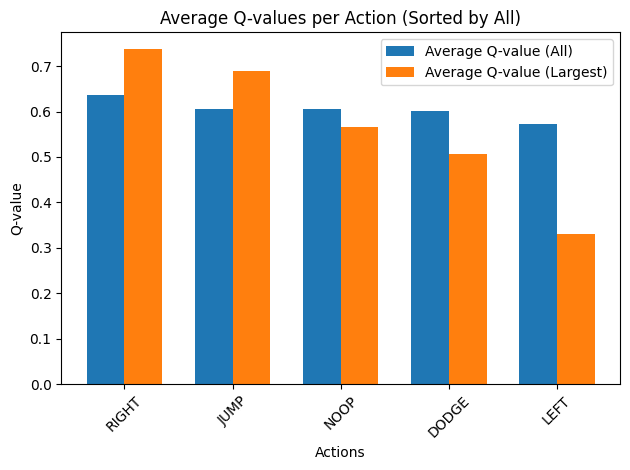

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average Q-values for all actions (first calculation)
average_q_values_all = [q_values[:, i].mean().item() for i in range(q_values.shape[1])]

# Compute average Q-values for actions when they are the largest (second calculation)
q_values_max, q_values_max_indices = q_values.max(dim=1)
unique_actions = torch.unique(q_values_max_indices)
average_q_values_largest = {}
for action in unique_actions:
    mask = (q_values_max_indices == action)  # Find indices where the action matches
    avg_q = q_values_max[mask].mean()  # Calculate the average Q-value for the action
    average_q_values_largest[action.item()] = avg_q.item()

# Ensure all actions are accounted for in the "largest" calculation
average_q_values_largest_list = [
    average_q_values_largest.get(i, 0) for i in range(q_values.shape[1])
]

# Sort actions based on descending average Q-values (all)
sorted_indices = np.argsort(-np.array(average_q_values_all))  # Negative for descending
sorted_action_names = [action_names[i] for i in sorted_indices]
sorted_q_values_all = [average_q_values_all[i] for i in sorted_indices]
sorted_q_values_largest = [average_q_values_largest_list[i] for i in sorted_indices]

# Define the positions for the bars
x = np.arange(len(sorted_action_names))

# Plot the bar chart
bar_width = 0.35  # Width of the bars
plt.bar(x - bar_width / 2, sorted_q_values_all, bar_width, label="Average Q-value (All)")
plt.bar(
    x + bar_width / 2, sorted_q_values_largest, bar_width, label="Average Q-value (Largest)"
)

# Add labels, title, and legend
plt.xlabel("Actions")
plt.ylabel("Q-value")
plt.title("Average Q-values per Action (Sorted by All)")
plt.xticks(x, sorted_action_names, rotation=45)  # Rotate x-axis labels if needed
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label clipping

# Show the plot
plt.show()

### Some Q-value statistics



In [50]:
# What is the average Q-value for each action when bullets are present and when they are not?
# Also, what is the average max Q-value?

concept = concept_instances['Visible bullet']
concept.prepare_data(env_steps, max_size=10000)
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)

train_bullet = train_obs[train_values == 1]
train_no_bullet = train_obs[train_values == 0]

q_values_bullet, _ = model(train_bullet, return_acts=True)
q_values_no_bullet, _ = model(train_no_bullet, return_acts=True)


bullet_means = q_values_bullet.mean(dim=0)
no_bullet_means = q_values_no_bullet.mean(dim=0)    

print("Q-value means (bullet / no bullet):")
for action in action_names:
    print(f"{action}: {bullet_means[action_names.index(action)]:.2f} / {no_bullet_means[action_names.index(action)]:.2f}")

print(f"Max Q-value: {q_values_bullet.max(dim=1)[0].mean():.2f} / {q_values_no_bullet.max(dim=1)[0].mean():.2f}")

Q-value means (bullet / no bullet):
NOOP: 0.55 / 0.66
LEFT: 0.52 / 0.63
RIGHT: 0.56 / 0.71
JUMP: 0.52 / 0.67
DODGE: 0.56 / 0.65
Max Q-value: 0.63 / 0.73


### Putting it all together in a function


Layer 8 TCAV scores are either 0 or 1 as they are invariant to the data. plt.hist is a bit buggy when all values are the same it seems...

In [15]:
all_layers = list(range(9))
activation_layers = [1, 3, 5, 8]

In [ ]:
def prepare_probe(concept, model, layer, max_size=10000):
    concept.prepare_data(env_steps, max_size=max_size)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)

    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)

    return lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy

In [16]:
def tcav_action0(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    
    fig, axes = plt.subplots(1, len(action_names), figsize=(5 * len(action_names), 4), sharey=True)
    if len(action_names) == 1:
        axes = [axes]  # Ensure axes is iterable

    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations)[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        
        ax = axes[idx]
        ax.hist(directional_derivatives, bins=50, color='skyblue')
        ax.set_xlabel('Conceptual sensitivity')
        ax.set_title(f"{action} | TCAV score={positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        if idx == 0:
            ax.set_ylabel('Frequency')
        ax.legend()

    fig.suptitle(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return round(positive_fraction, 3)

In [17]:
def tcav_action(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights  # / np.linalg.norm(flat_weights)
    
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("tab10", len(action_names))  # Seaborn's color palette

    positive_fractions = {}
    
    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations)[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        positive_fractions[action] = positive_fraction
        
        # Plot KDE instead of histogram
        sns.kdeplot(directional_derivatives, 
                    fill=True, 
                    color=colors[idx], 
                    label=f"{action} | TCAV={positive_fraction:.2f}",
                    bw_adjust=1)  # Adjust bw_adjust for smoothing

    plt.xlabel('Conceptual Sensitivity')
    plt.ylabel('Density')
    plt.title(f"{concept.name} | Accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    plt.axvline(x=0, color='k', linestyle='--', label='Zero')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {action: round(frac, 3) for action, frac in positive_fractions.items()}

In [37]:
def tcav_action(concept, layer, ax=None):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights  # / np.linalg.norm(flat_weights)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    colors = sns.color_palette("tab10", len(action_names))  # Seaborn's color palette

    positive_fractions = {}
    
    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations)[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        positive_fractions[action] = positive_fraction
        
        # Plot KDE instead of histogram on provided axis
        sns.kdeplot(
            directional_derivatives, 
            fill=True, 
            color=colors[idx], 
            label=f"{action} | TCAV={positive_fraction:.2f}",
            bw_adjust=1, 
            ax=ax
        )

    ax.set_xlabel('Conceptual Sensitivity')
    ax.set_ylabel('Density')
    ax.set_title(f"{concept.name} | Accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    ax.axvline(x=0, color='k', linestyle='--', label='Zero')
    ax.legend()
    
    # Only show the plot if no Axes were provided
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return positive_fractions

In [40]:
def tcav_max(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    test_activations = acts_dict_test[layer]
    test_activations.requires_grad_(True)

    max_q_values = model.network[layer + 1:](test_activations).max(dim=1)[0]
    max_q_values.backward(torch.ones_like(max_q_values))
    activations_grad = test_activations.grad.clone()
    test_activations.requires_grad_(False)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    directional_derivatives = np.dot(flat_activations_grad, norm_direction)

    positive_fraction = np.mean(directional_derivatives > 0)
    plt.figure(figsize=(6, 4))
    plt.hist(directional_derivatives, bins=50, color='skyblue')
    plt.xlabel('Conceptual sensitivity')
    plt.ylabel('Frequency')
    plt.title(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV score={positive_fraction:.2f}")

    plt.axvline(x=0, color='r', linestyle='--', label='Zero')
    plt.tight_layout()
    plt.legend()
    # plt.show()
    return round(positive_fraction, 3)


In [19]:
def tcav_softmax(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    
    fig, axes = plt.subplots(1, len(action_names), figsize=(5 * len(action_names), 4), sharey=True)
    if len(action_names) == 1:
        axes = [axes]  # Ensure axes is iterable

    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations).softmax(dim=1)[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        
        ax = axes[idx]
        ax.hist(directional_derivatives, bins=50, color='skyblue')
        ax.set_xlabel('Conceptual sensitivity')
        ax.set_title(f"{action} | TCAV score={positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        if idx == 0:
            ax.set_ylabel('Frequency')
        ax.legend()

    fig.suptitle(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return round(positive_fraction, 3)

In [20]:
def tcav_linear_softmax(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    
    fig, axes = plt.subplots(1, len(action_names), figsize=(5 * len(action_names), 4), sharey=True)
    if len(action_names) == 1:
        axes = [axes]  # Ensure axes is iterable

    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations)
        q_values = q_values / q_values.sum(dim=1, keepdim=True)
        q_values = q_values[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        
        ax = axes[idx]
        ax.hist(directional_derivatives, bins=50, color='skyblue')
        ax.set_xlabel('Conceptual sensitivity')
        ax.set_title(f"{action} | TCAV score={positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        if idx == 0:
            ax.set_ylabel('Frequency')
        ax.legend()

    fig.suptitle(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return round(positive_fraction, 3)

In [21]:
def tcav_action_ratio(concept, layer, action1, action2):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    test_activations = acts_dict_test[layer]
    test_activations.requires_grad_(True)

    max_q_values = model.network[layer + 1:](test_activations)
    max_q_values = max_q_values[:, action1] / max_q_values[:, action2]
    max_q_values.backward(torch.ones_like(max_q_values))
    activations_grad = test_activations.grad.clone()
    test_activations.requires_grad_(False)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    directional_derivatives = np.dot(flat_activations_grad, norm_direction)

    positive_fraction = np.mean(directional_derivatives > 0)
    
    plt.figure(figsize=(6, 4))
    plt.hist(directional_derivatives, bins=50, color='skyblue')
    plt.xlabel('Conceptual sensitivity')
    plt.ylabel('Frequency')
    plt.title(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | {action_names[action1]} / {action_names[action2]} TCAV score={positive_fraction:.2f}")

    plt.axvline(x=0, color='r', linestyle='--', label='Zero')
    plt.tight_layout()
    plt.legend()
    plt.show()
    return round(positive_fraction, 3)

In [22]:
def tcav_action_ratio2(concept, layer, action1, action2):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    test_activations = acts_dict_test[layer]
    test_activations.requires_grad_(True)

    max_q_values = model.network[layer + 1:](test_activations)
    max_q_values = max_q_values[:, action1] / (max_q_values[:, action1] + max_q_values[:, action2])
    max_q_values.backward(torch.ones_like(max_q_values))
    activations_grad = test_activations.grad.clone()
    test_activations.requires_grad_(False)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    directional_derivatives = np.dot(flat_activations_grad, norm_direction)

    positive_fraction = np.mean(directional_derivatives > 0)
    
    plt.figure(figsize=(6, 4))
    plt.hist(directional_derivatives, bins=50, color='skyblue')
    plt.xlabel('Conceptual sensitivity')
    plt.ylabel('Frequency')
    plt.title(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | {action_names[action1]} / {action_names[action2]} TCAV score={positive_fraction:.2f}")

    plt.axvline(x=0, color='r', linestyle='--', label='Zero')
    plt.tight_layout()
    plt.legend()
    plt.show()
    return round(positive_fraction, 3)

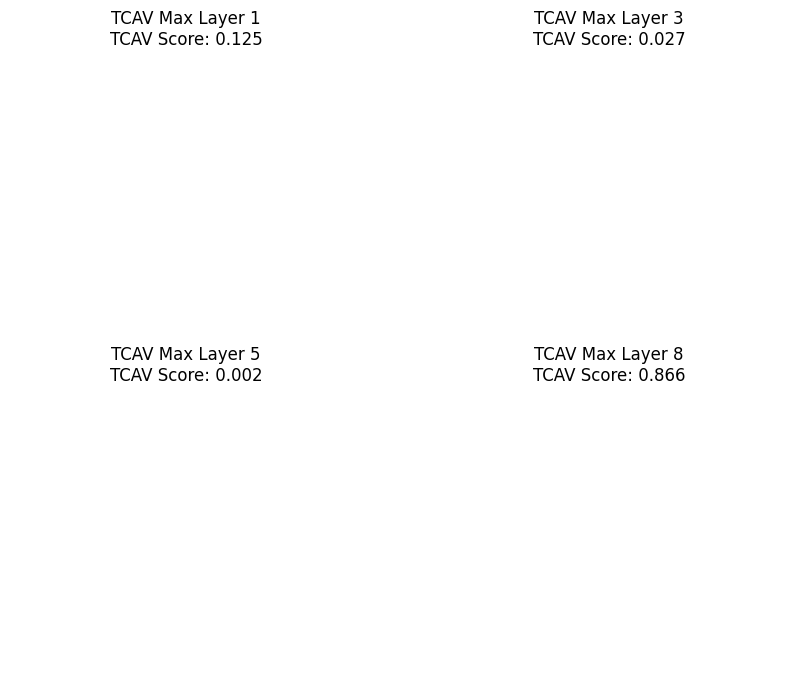

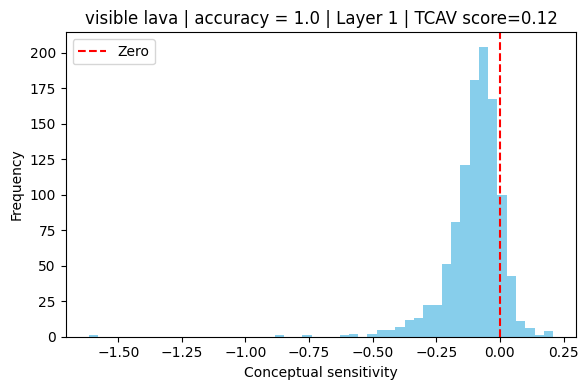

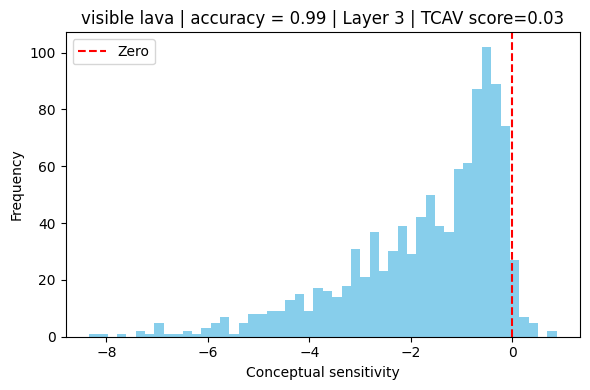

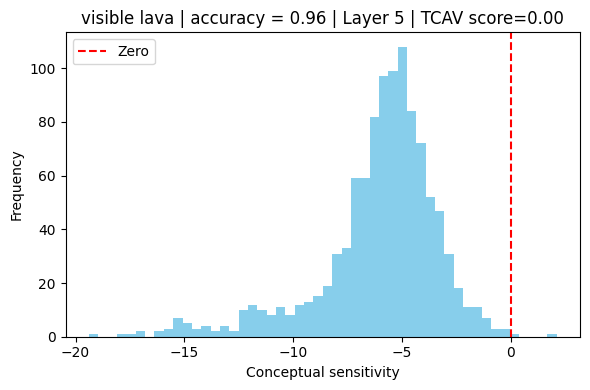

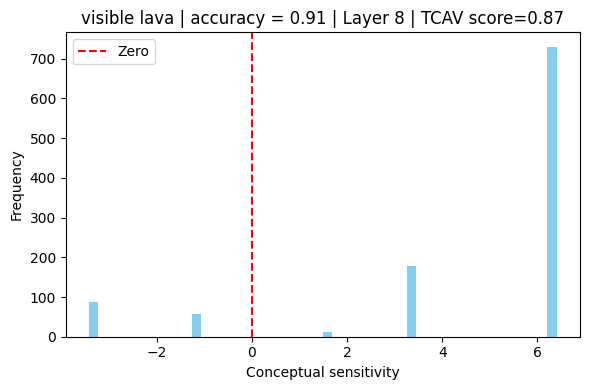

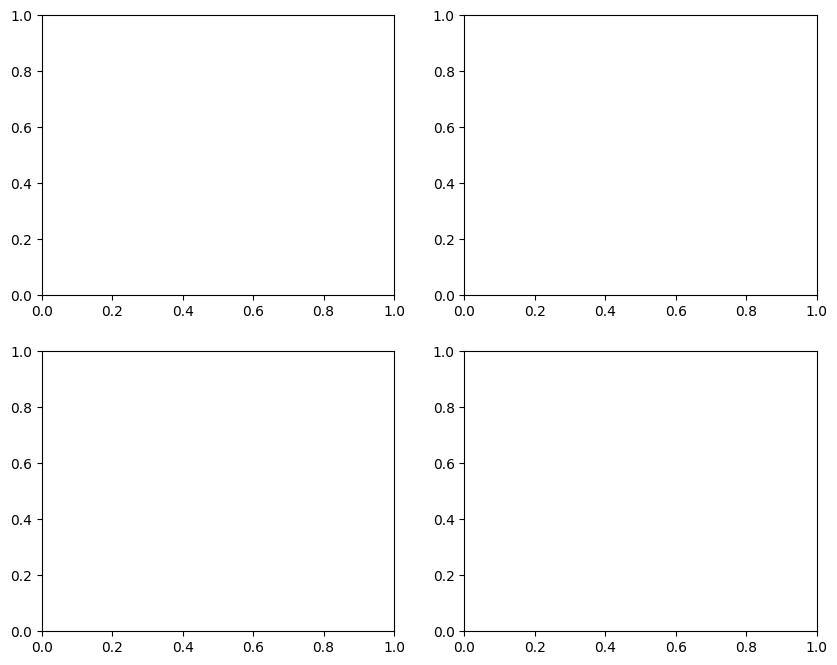

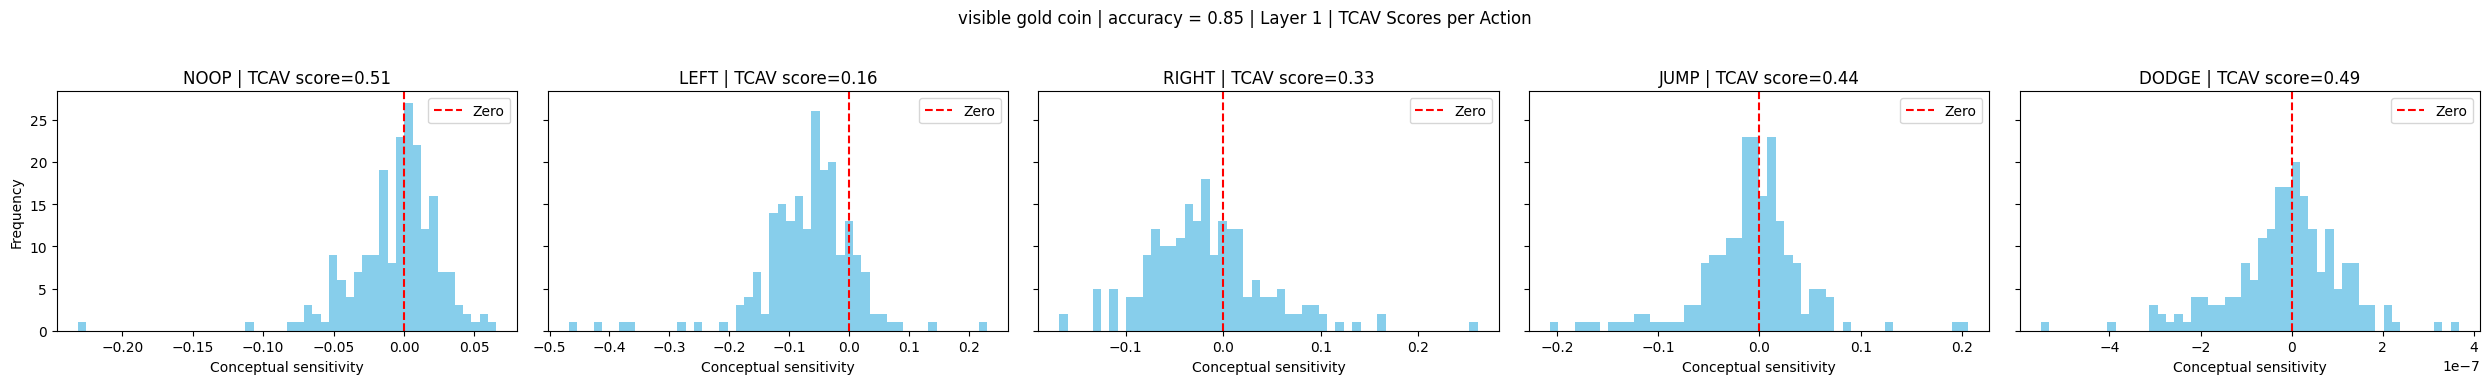

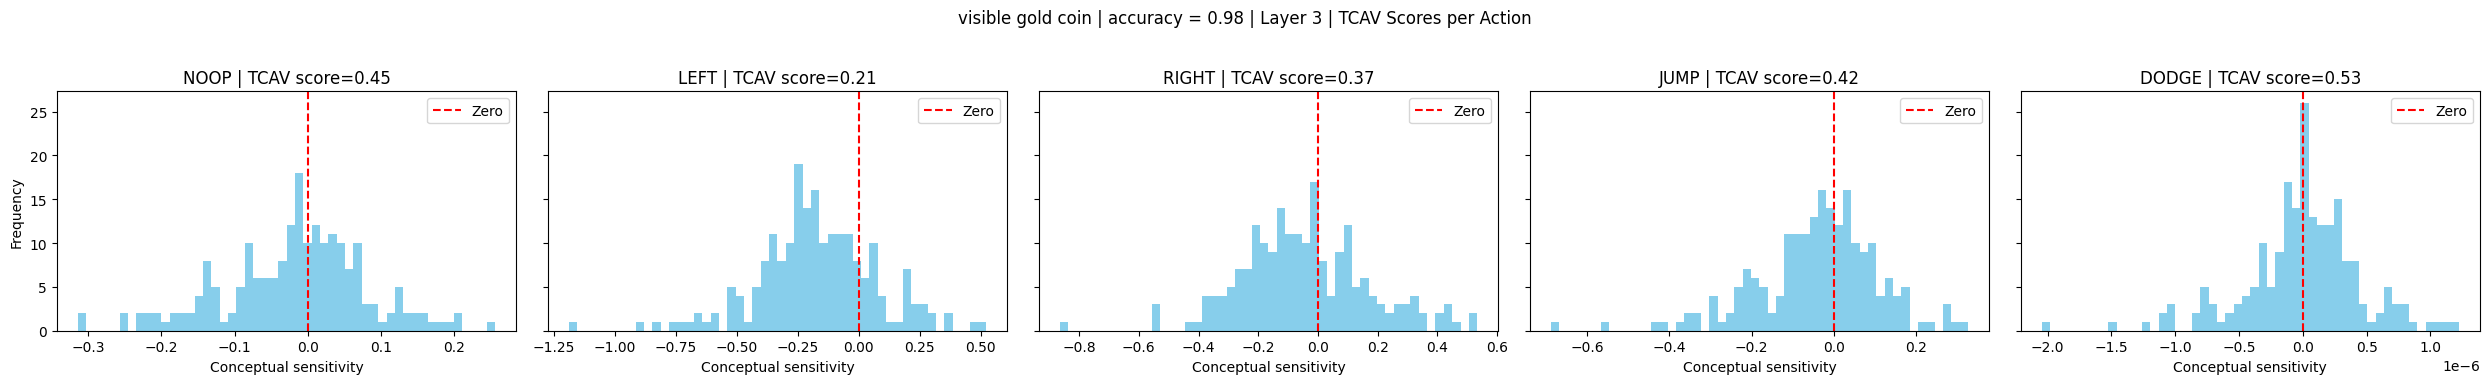

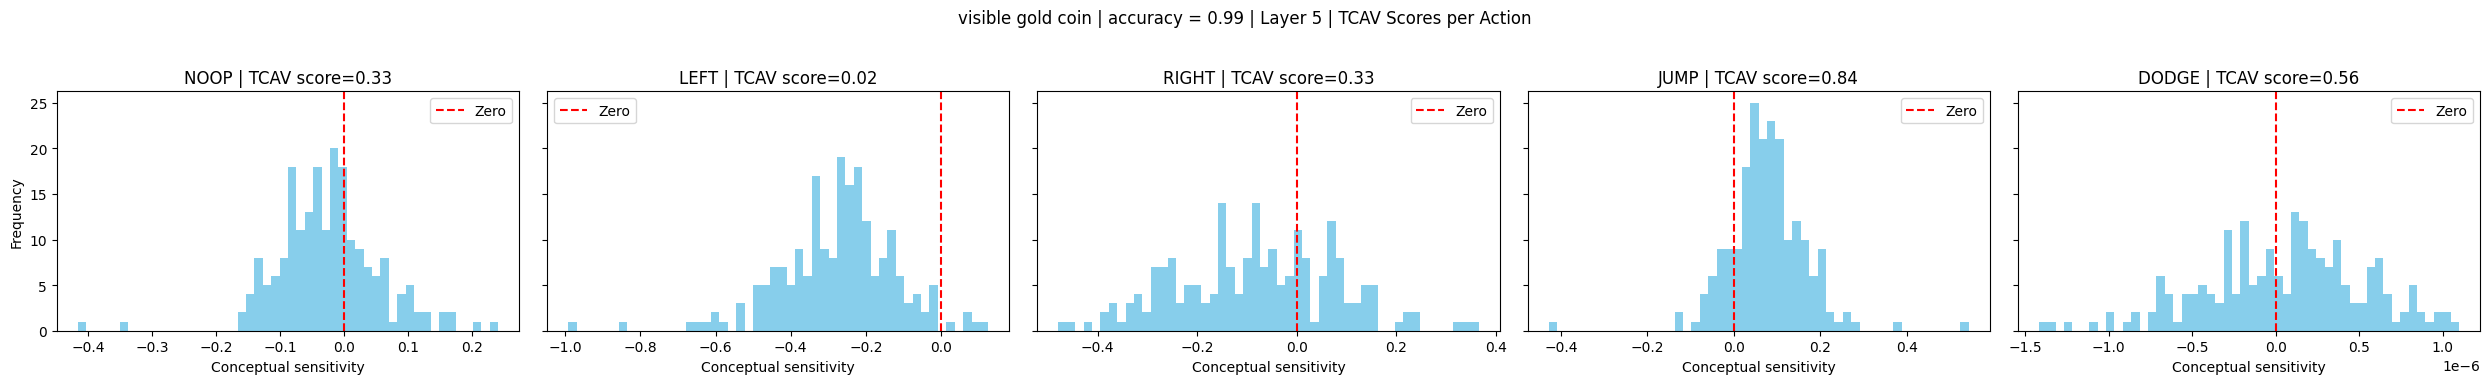

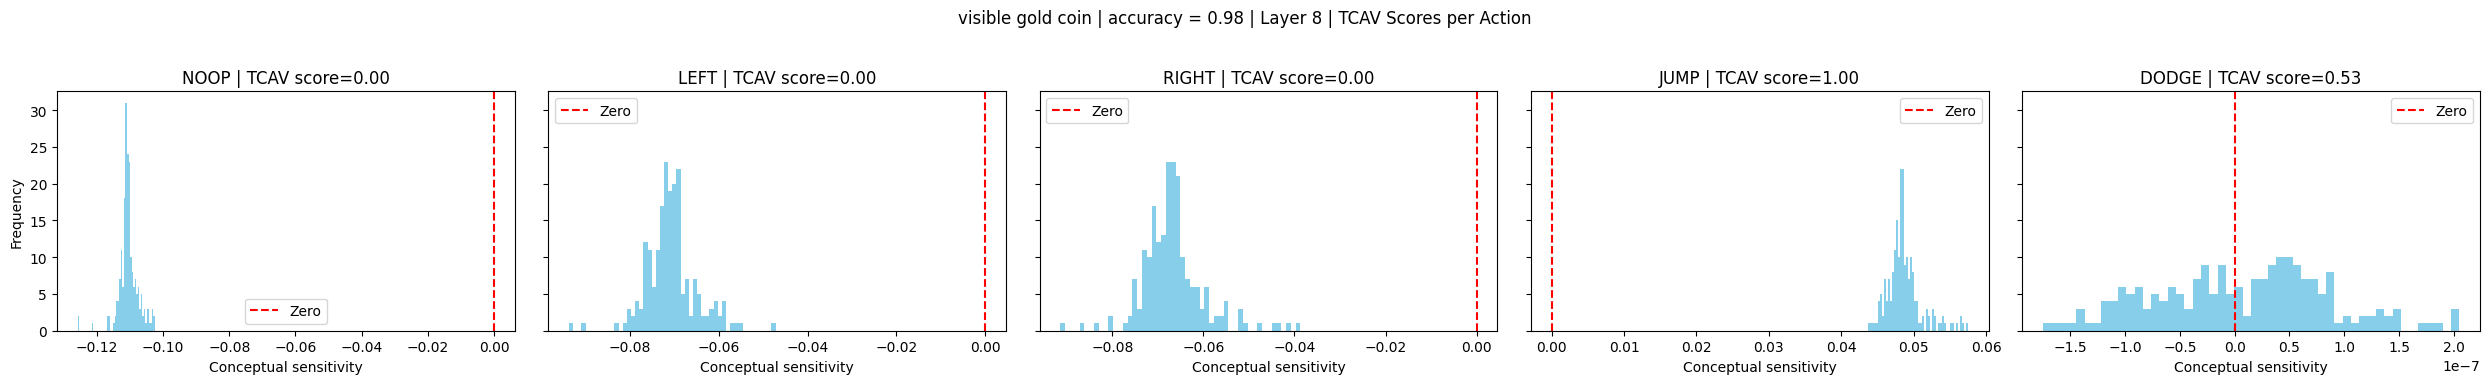

<Figure size 640x480 with 0 Axes>

In [41]:
def plot_tcav_scores(tcav_function, concept, layer_indices, title_prefix):
    num_layers = len(layer_indices)
    grid_size = int(np.ceil(np.sqrt(num_layers)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(5 * grid_size, 4 * grid_size))
    axes = axes.flatten()
    scores = []

    for ax, layer in zip(axes, layer_indices):
        score = tcav_function(concept, layer)
        scores.append(score)
        ax.set_title(f"{title_prefix} Layer {layer}\nTCAV Score: {score}")
        ax.axis('off')  # Hide axes for clarity

    # Hide any unused subplots
    for ax in axes[num_layers:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    return scores

# Example usage for tcav_max
concept = concept_instances['Visible lava']
scores_tcav_max = plot_tcav_scores(tcav_max, concept, activation_layers, "TCAV Max")

# Example usage for tcav_softmax
concept = concept_instances['Visible gold coin']
scores_tcav_softmax = plot_tcav_scores(tcav_softmax, concept, activation_layers, "TCAV Softmax")

/tmp/ipykernel_1120957/3327521100.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_1120957/3327521100.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


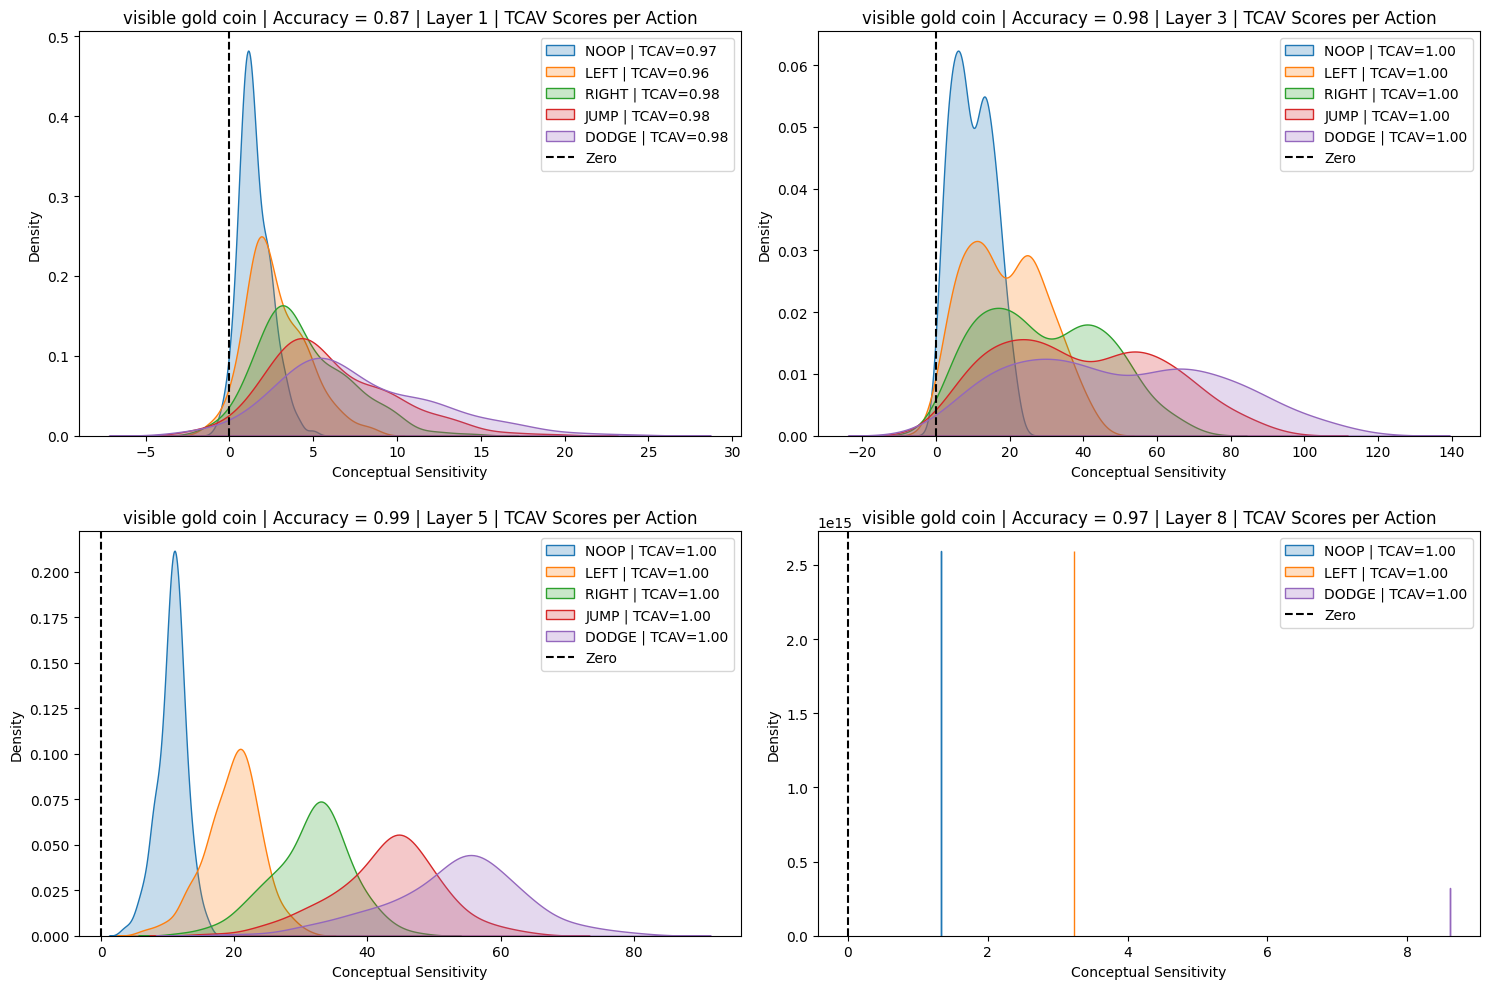

In [38]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
concept = concept_instances['Visible gold coin']
axes = axes.flatten()
for ax, layer in zip(axes, activation_layers):
    scores = tcav_action(concept, layer, ax=ax)

plt.tight_layout()
plt.show()

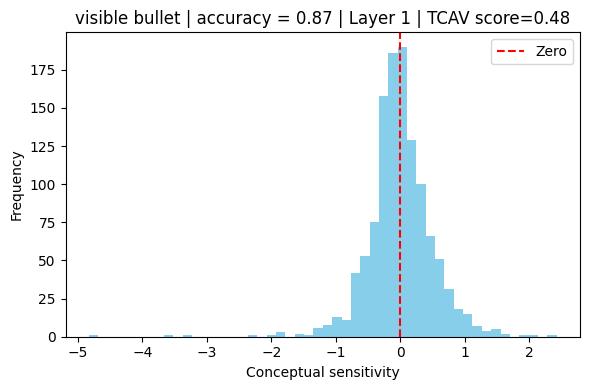

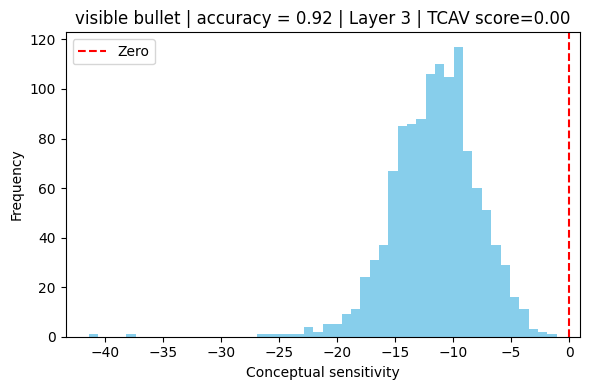

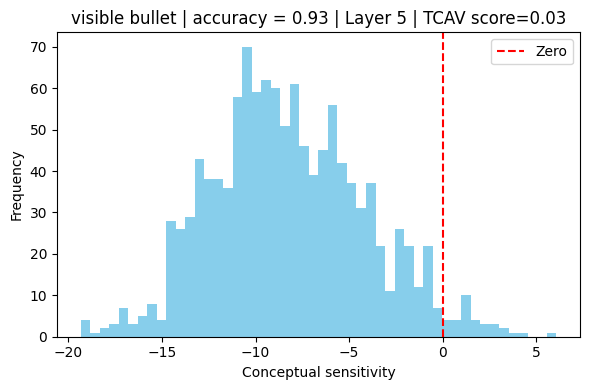

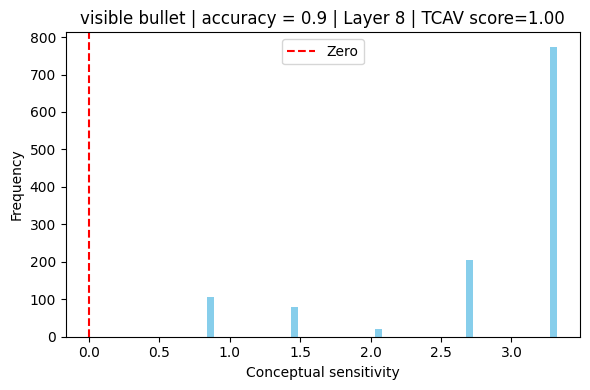

[0.48, 0.0, 0.028, 1.0]


In [24]:
scores = []
for layer in activation_layers:
    scores.append(tcav_max(concept_instances['Visible bullet'], layer))
print(scores)

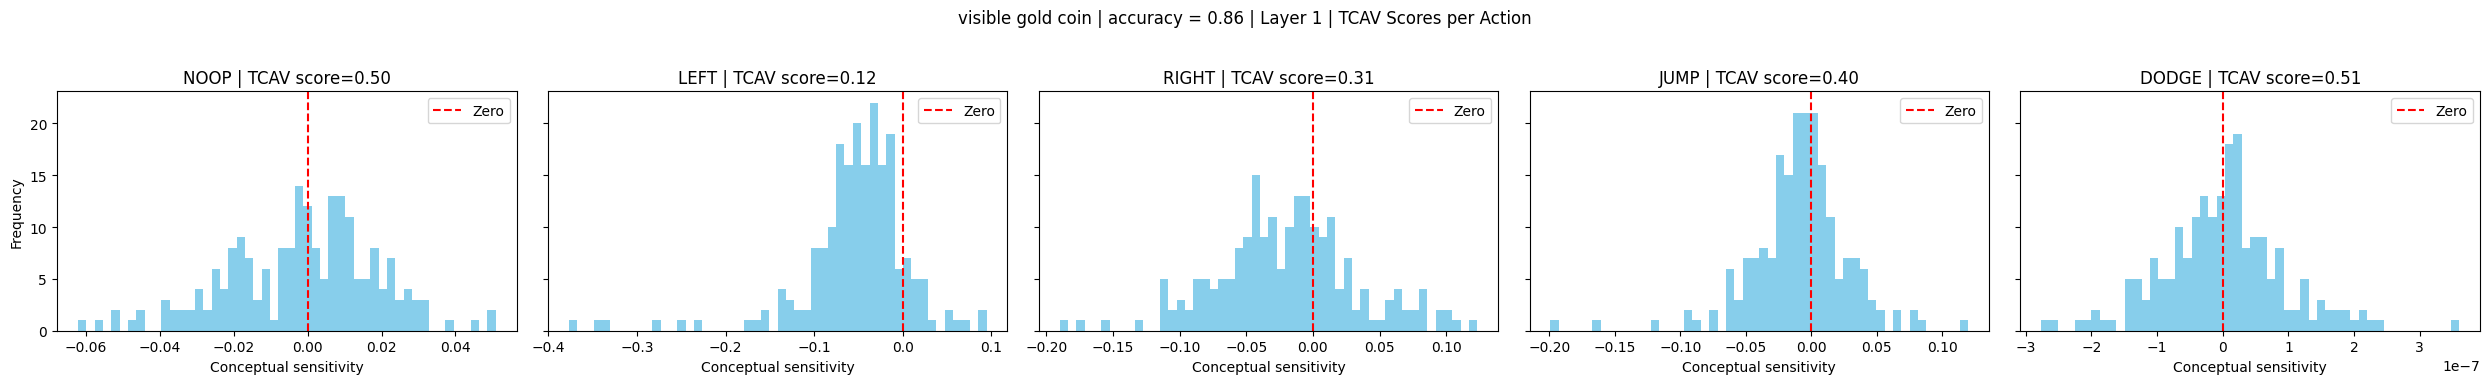

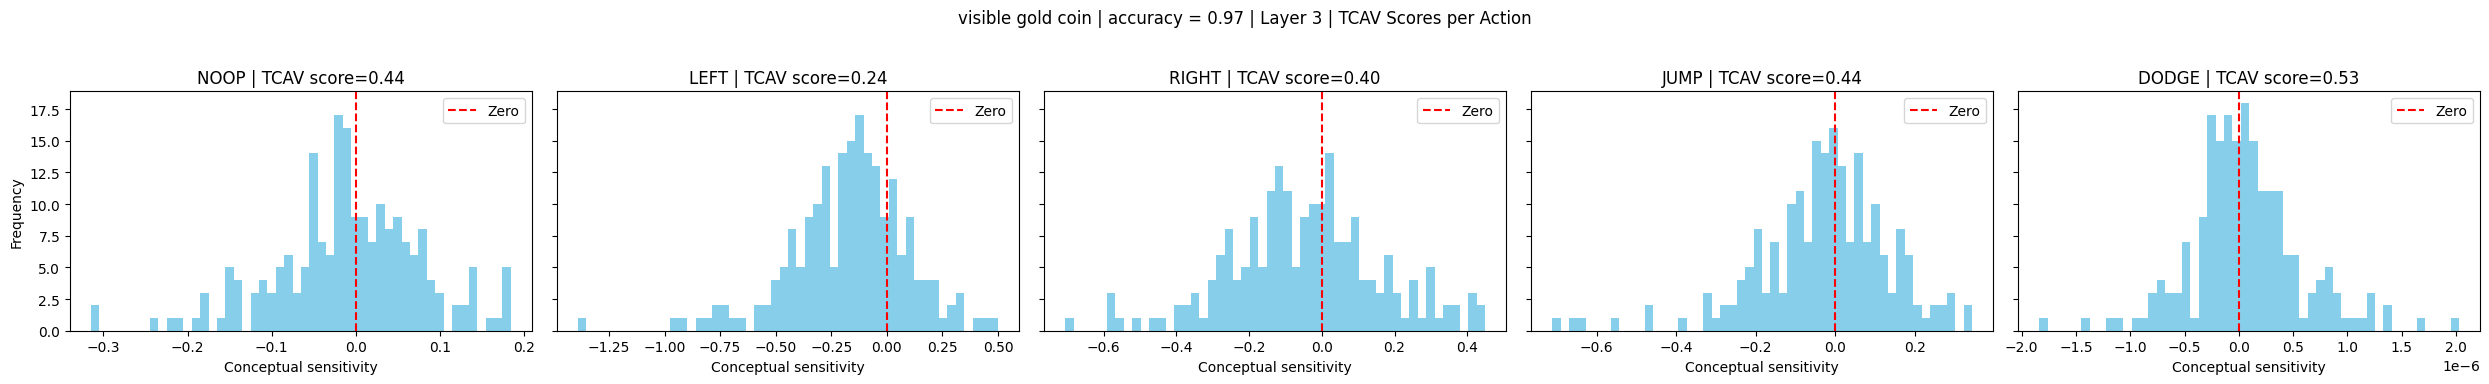

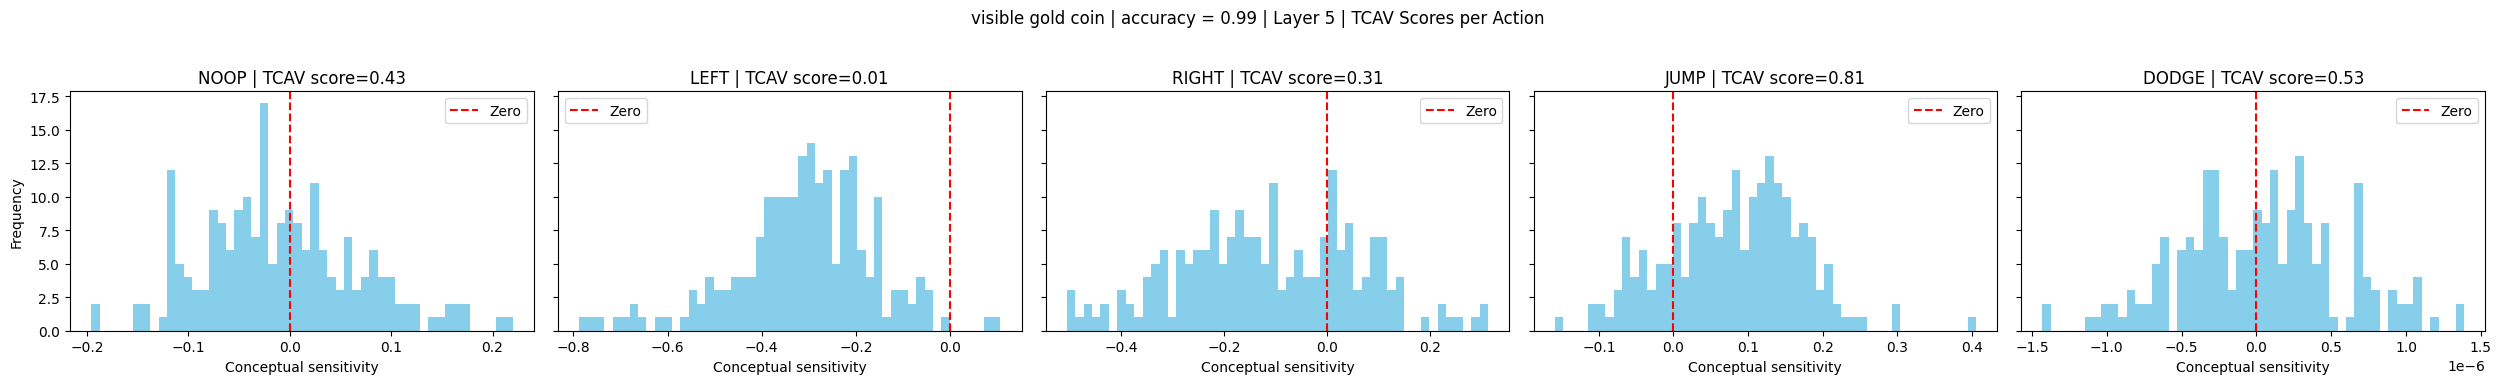

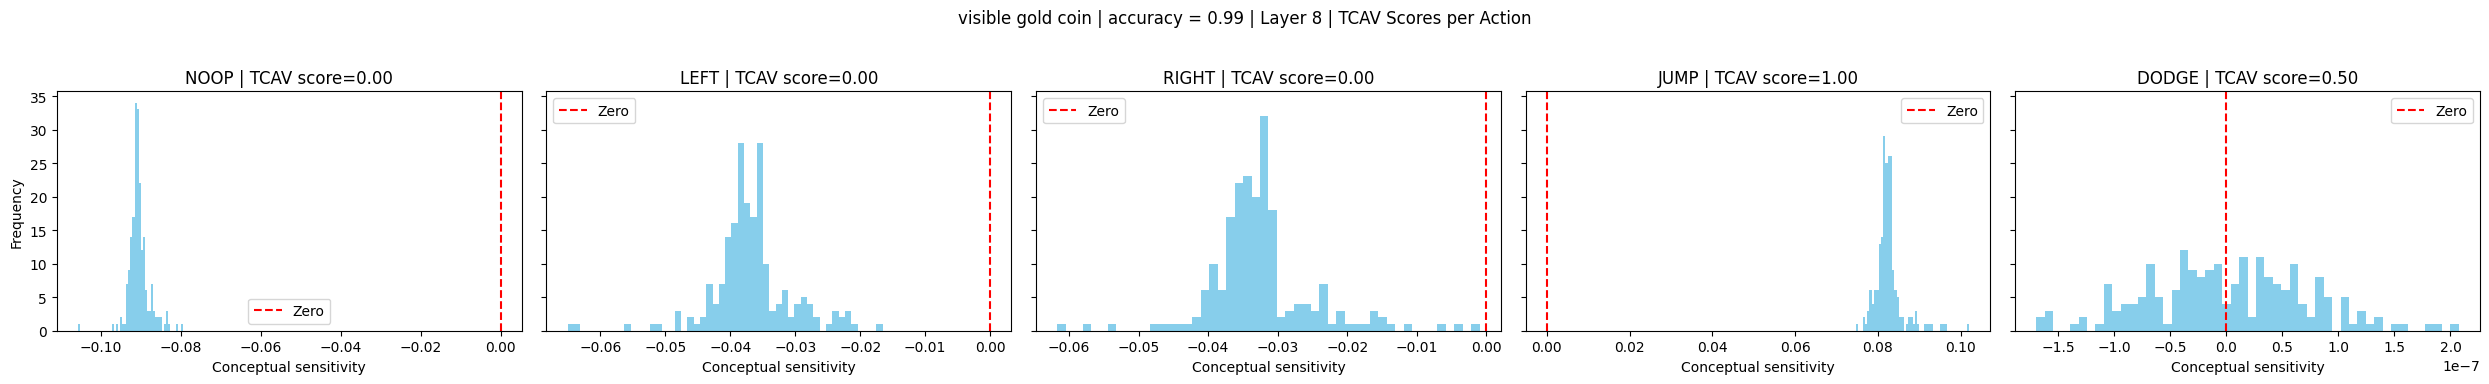

[0.51, 0.529, 0.534, 0.495]


In [25]:
scores = []
for layer in activation_layers:
    scores.append(tcav_softmax(concept_instances['Visible gold coin'], layer))
print(scores)

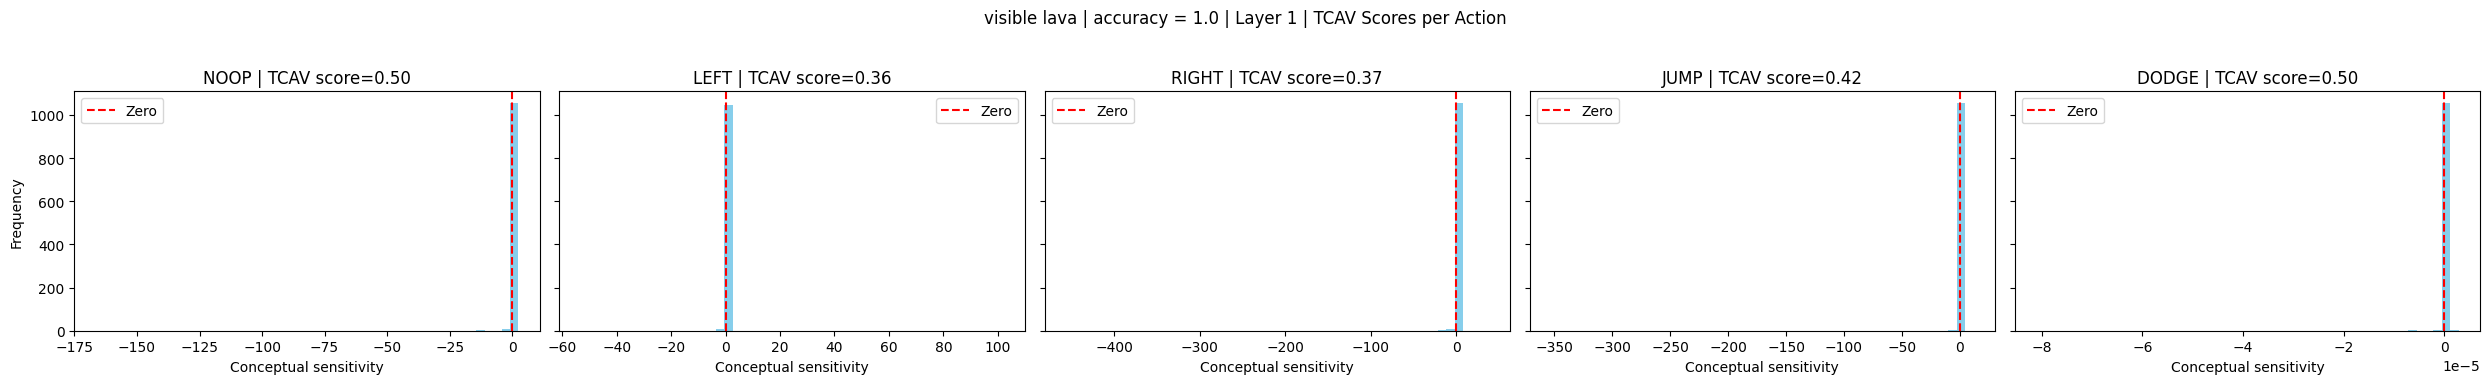

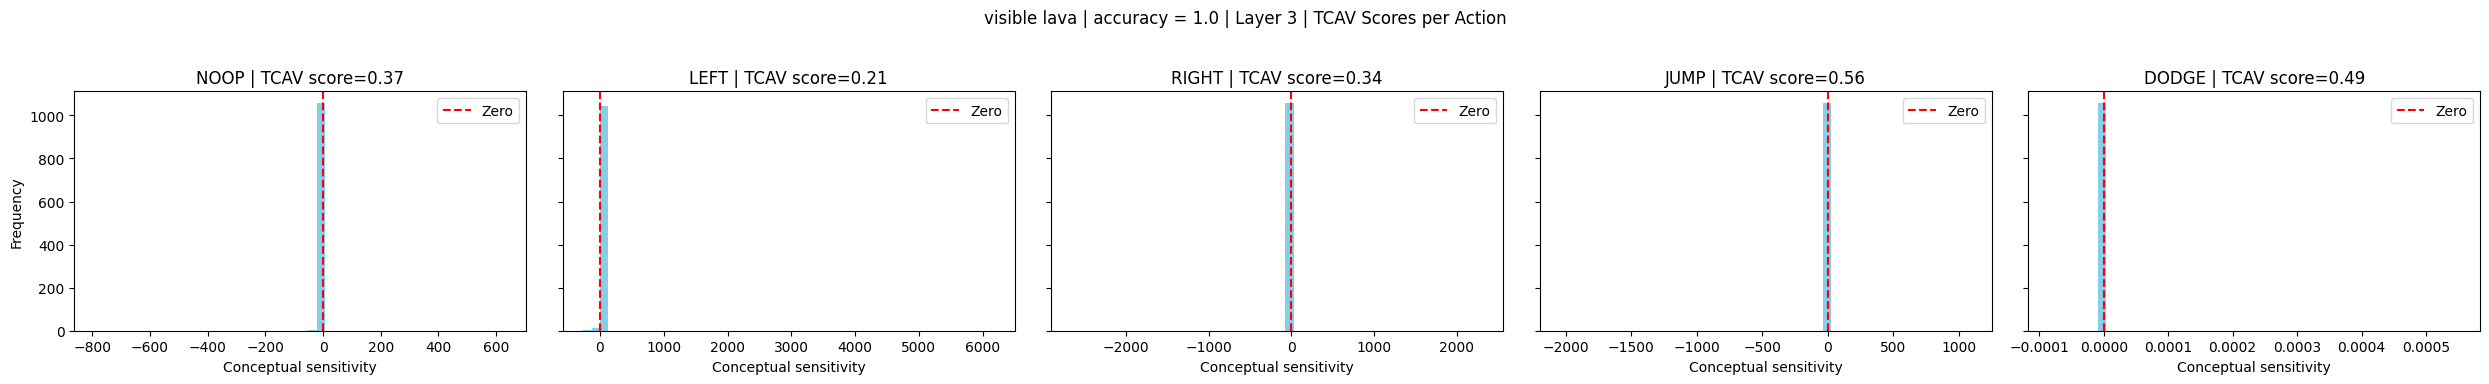

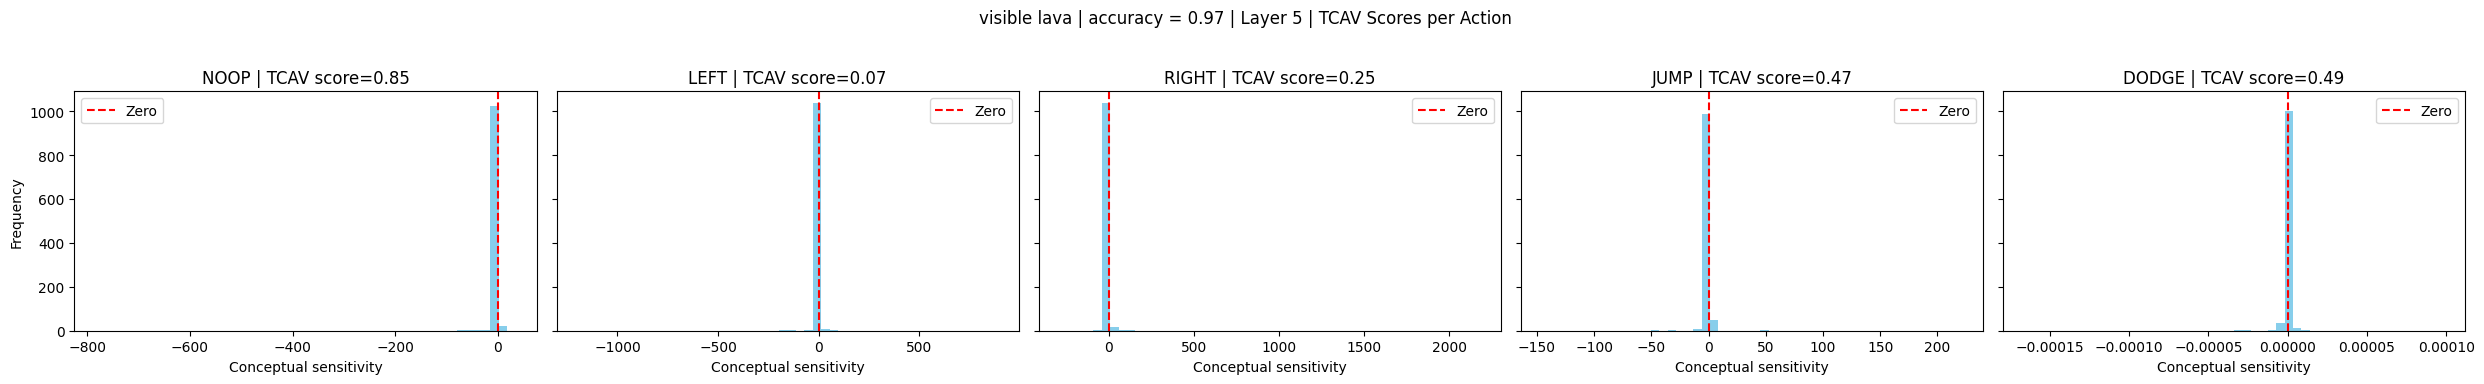

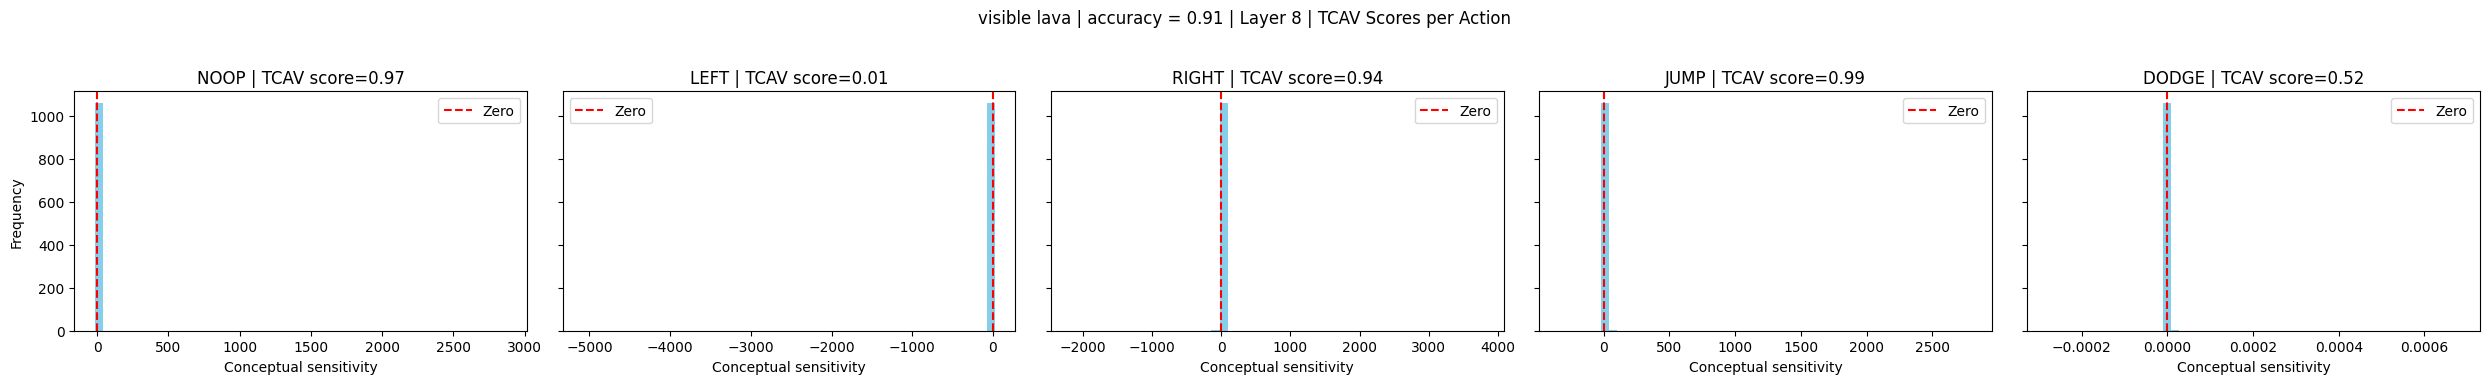

[0.497, 0.486, 0.49, 0.516]


In [26]:
scores = []
for layer in activation_layers:
    scores.append(tcav_linear_softmax(concept_instances['Visible lava'], layer))
print(scores)

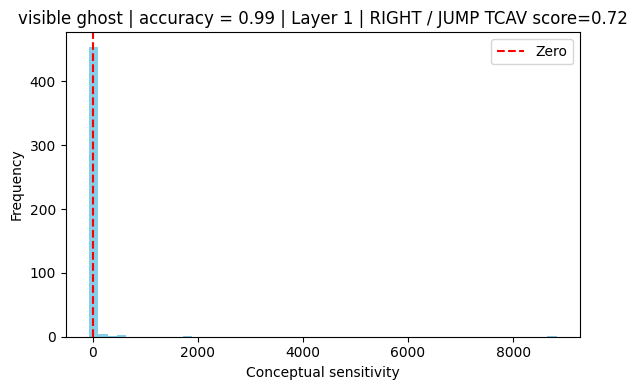

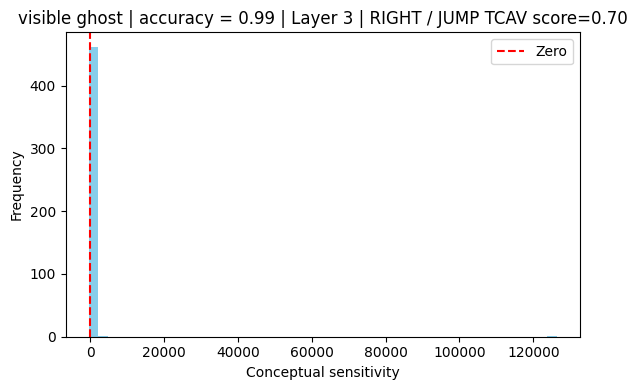

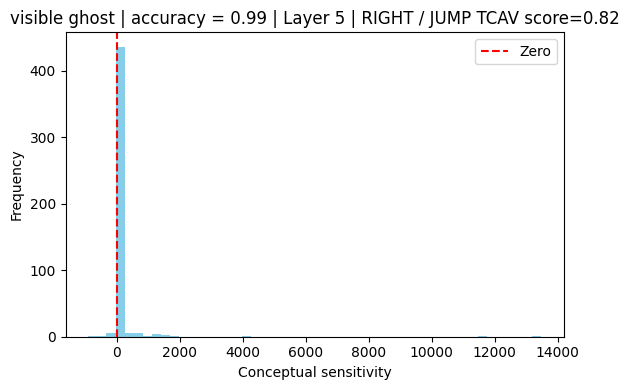

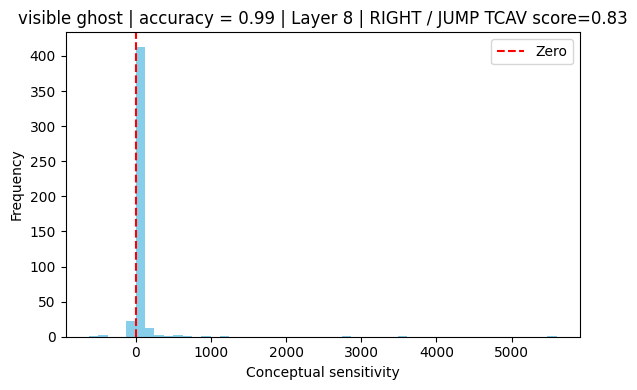

[0.722, 0.696, 0.819, 0.83]


In [27]:
scores = []
for layer in activation_layers:
    scores.append(tcav_action_ratio(concept_instances['Visible ghost'], layer, action_names.index('RIGHT'), action_names.index('JUMP')))
print(scores)

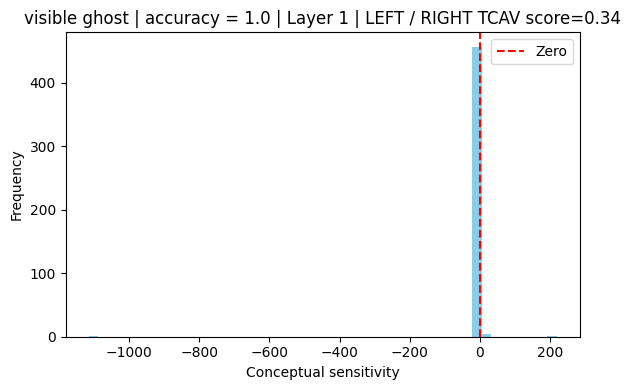

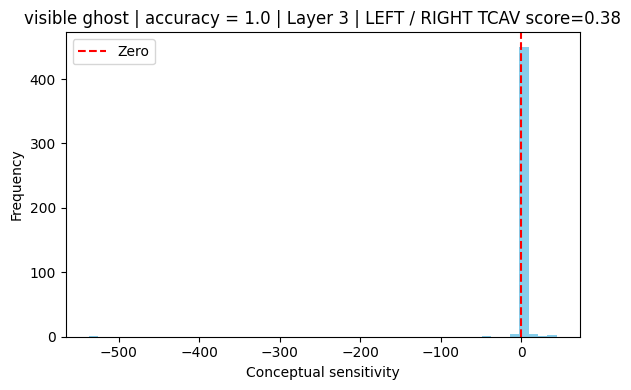

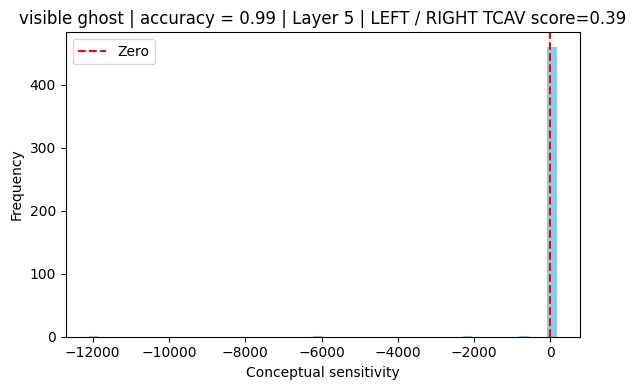

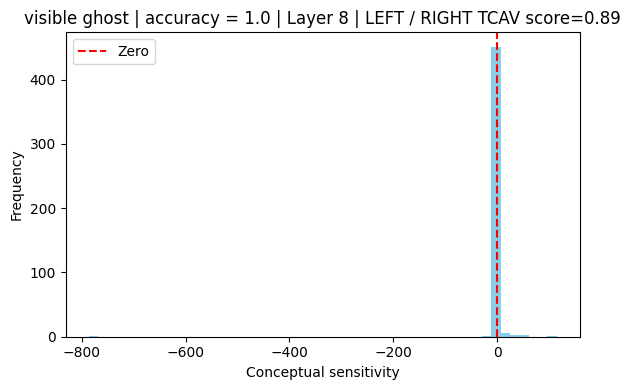

[0.345, 0.381, 0.392, 0.888]


In [28]:
scores = []
for layer in activation_layers:
    scores.append(tcav_action_ratio2(concept_instances['Visible ghost'], layer, action_names.index('LEFT'), action_names.index('RIGHT')))
print(scores)